# Aprendizado de Máquina em Séries Temporais

### Modelo SARIMA para predição de temperaturas de SST - Sea Surface Temperature Forecasting

### Introdução

Modelos SARIMA são modelos univariados para séries temporais. O acrônimo SARIMA significa modelos AutoRegressivos Integrados de Médias Móveis com Sazonalidade. [Referência](https://analisemacro.com.br/economia/comentario-de-conjuntura/modelos-sarima/)

Neste projeto vamos treinar vários modelos SARIMAs para prever as próximas temperaturas numa janela de tempo que chamamos de HORIZONTE.

Primeiro fazemos o treino e teste para o ponto dado (latitude e longitude) do planeta. Os pontos escolhidos são descritos mais adiante.

Finalmente fazemos um tipo de validação cruzada, que pra modelos de séries temporas tal como o SARIMA, essa validação é chamada de `walk-foward validation`

In [7]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

In [8]:
from netuno import SSTHelper

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### Variáis globais para esse arquivo

In [9]:
HORIZONTE = 12 # número de previsões a serem feitas (à frente da data)
AUTO_TUNE = True # se False, não faz a otimização de hiperparâmetros com o auto_arima (demorado)
DATE_TO_SPLIT = '2021-12-01' #data limite para dividir em treino[:DATA_LIMITE] e teste[DATA_LIMITE:]

### Carrengando o dataset

In [10]:
fp = '../dados/sst.mnmean.nc'
ds = SSTHelper.load_dataset(fp)

In [11]:
df = SSTHelper.load_dataframe(ds)

In [12]:
df.head()

,lat,lon,time,nbnds,time_bnds,sst
0,88.0,0.0,1854-01-01,0,9.969210e+36,-1.8
2,88.0,0.0,1854-02-01,0,9.969210e+36,-1.8
4,88.0,0.0,1854-03-01,0,9.969210e+36,-1.8
6,88.0,0.0,1854-04-01,0,9.969210e+36,-1.8
8,88.0,0.0,1854-05-01,0,9.969210e+36,-1.8


### Definindo os pontos do globo que serão usados

* P1: Um ponto na região do ENSO;
 -> lat = 20°, lon = -132° (https://www.google.com.br/maps/place/20%C2%B000'00.0%22N+132%C2%B000'00.0%22W/@22.1775213,-151.1364928,3.87z/data=!4m4!3m3!8m2!3d20!4d-132?entry=ttu)

* P2: Um ponto na costa do Chile (Corrente de Humboldt);
 -> lat = -22°, lon = -72° (https://www.google.com.br/maps/place/22%C2%B000'00.0%22S+72%C2%B000'00.0%22W/@-21.7898533,-87.474343,4.04z/data=!4m4!3m3!8m2!3d-22!4d-72?entry=ttu)

* P3: Um ponto no meio do Mediterrâneo;
 -> lat = 36°, lon = 18° (https://www.google.com.br/maps/place/36%C2%B000'00.0%22N+18%C2%B000'00.0%22E/@36.0000043,17.9974251,17z/data=!3m1!4b1!4m4!3m3!8m2!3d36!4d18?entry=ttu)

* P4: Um ponto no meio do Atlântico;
 -> lat = 0°, lon = -22° (https://www.google.com.br/maps/place/0%C2%B000'00.0%22N+22%C2%B000'00.0%22W/@-11.0144452,-50.6148726,3z/data=!4m3!3m2!8m1!4d-22?entry=ttu)

* P5: Um ponto no extremo Índico (ponto de maior latitude, temperaturas mais baixas)
 -> lat = -56°, lon = 80° (https://www.google.com.br/maps/place/56%C2%B000'00.0%22S+80%C2%B000'00.0%22E/@-36.027701,54.6888129,3z/data=!4m4!3m3!8m2!3d-56!4d80?entry=ttu)

#### Obtendo as séries dos pontos definidos

In [13]:
p1_enso   = SSTHelper.get_sst_series_default(df,  20  ,-132)
p2_chile  = SSTHelper.get_sst_series_default(df, -22  , -72)
p3_medit  = SSTHelper.get_sst_series_default(df,  36  ,  18)
p4_atlan  = SSTHelper.get_sst_series_default(df,  0   , -22)
p5_indic  = SSTHelper.get_sst_series_default(df,  -56 ,  80)

#### Verificando se os pontos do dataset foram carregados corretamente

In [14]:
p1_enso.head()
# p2_chile.head() 
# p3_medit.head()
# p4_atlan.head()
# p5_indic.head()

,lat,lon,sst
time,,,
1854-01-01,20.0,-132.0,22.197483
1854-02-01,20.0,-132.0,21.905436
1854-03-01,20.0,-132.0,22.155600
1854-04-01,20.0,-132.0,22.680405
1854-05-01,20.0,-132.0,22.942524


#### Plotando a temperatura de um ponto do globo através do tempo. Ponto: ENSO -> El Niño-Southern Oscillation

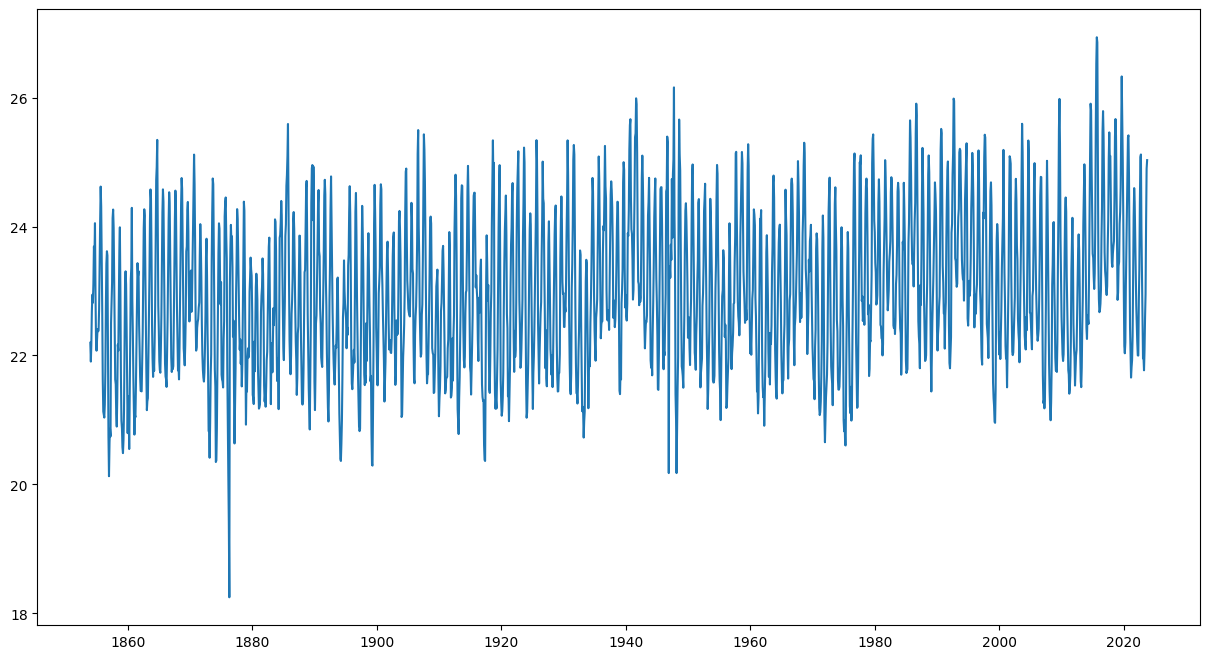

In [15]:
# para toda a séries p1_enso
index = p1_enso.index.tolist()
plt.figure(figsize=(15,8))
plt.plot(index, p1_enso['sst'])
plt.show()

#### Plotando para as primeiras leituras

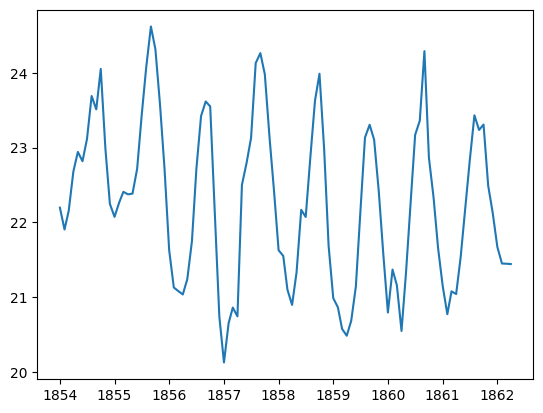

In [16]:
#plotando a temperatura do ponto atravéz do tempo para as primeiras 100 leituras
index = p1_enso.index.tolist()
plt.plot(index[:100],p1_enso['sst'][:100])
plt.show()

### Dividindo em treino e teste para os pontos do globo escolhidos, no caso o ENSO

In [17]:
END_WINDOW = HORIZONTE #janela para usar como teste no conjunto de teste 

# enso
treino_enso, teste_enso = SSTHelper.split_train_test(p1_enso, DATE_TO_SPLIT)
treino_enso.drop(['lat', 'lon'], axis=1, inplace=True)
teste_enso.drop(['lat', 'lon'], axis=1, inplace=True)

# IR PARA SEÇÃO ANEXO para realizar a previsão para os outros pontos definidos

In [18]:
print('Shape de treino (ENSO): ', treino_enso.shape)
print('Shape de teste (ENSO): ' , teste_enso.shape)

Shape de treino (ENSO):  (2016, 1)
Shape de teste (ENSO):  (22, 1)


#### Dados de treino (ENSO)

In [19]:
treino_enso.tail()

,sst
time,
2021-08-01,24.145559
2021-09-01,24.596079
2021-10-01,24.381094
2021-11-01,23.861654
2021-12-01,23.306463


#### Dados de teste (ENSO) - limitado ao horizonte

In [20]:
teste_enso.tail(HORIZONTE)

,sst
time,
2022-11-01,23.949959
2022-12-01,23.302540
2023-01-01,22.738529
2023-02-01,21.955500
2023-03-01,21.979300
2023-04-01,21.770193
2023-05-01,22.074417
2023-06-01,22.585289
2023-07-01,22.950830


### Otimizando os hiper-parâmetros do SARIMA para o conjunto de treino do ENSO

Os hiperparâmetros `order`$= (p, q, d)$ e `sazonal_order`$=(P, Q, D, m)$ usados para treinar o modelos serão obtido pelo otimizador **auto_arima** do seguinte pacote, https://alkaline-ml.com/pmdarima/

O hiperparãmetro `order` é um parâmetro que tem a ver com a parte de trending do modelo:

 - $p$: Trend autoregression order

 - $q$: Moving average order

 - $d$: Trend moving average order

e os parâmetros de sazonalidade referente ao `sazonal_order`:

 - $P$: Seasonal autoregressive order

 - $D$: Seasonal difference order

 - $Q$: Seasonal moving average order

 - $m$: o número de passos no tempo para um único período de sazonalidade

#### Otimizator auto_arima :


In [21]:
# https://alkaline-ml.com/pmdarima/
import pmdarima as pm

# Procura pelos melhores parâmetros (order e seasonal_order)
if (AUTO_TUNE):
    auto_model = pm.auto_arima(treino_enso, start_p=1, start_q=0,
                               max_p=5, max_q=0, m=24,
                               start_P=0, max_P=2,Q=0, 
                               seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    print(auto_model.aic())
    print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=inf, Time=22.86 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=3270.504, Time=0.38 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=2709.528, Time=5.19 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=inf, Time=20.18 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=3257.862, Time=0.48 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=2498.145, Time=7.75 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=102.74 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=30.86 sec
 ARIMA(0,1,0)(2,1,0)[24]             : AIC=2514.605, Time=7.90 sec
 ARIMA(2,1,0)(2,1,0)[24]             : AIC=2463.490, Time=15.44 sec
 ARIMA(2,1,0)(1,1,0)[24]             : AIC=2670.137, Time=6.50 sec
 ARIMA(2,1,0)(2,1,1)[24]             : AIC=inf, Time=207.25 sec
 ARIMA(2,1,0)(1,1,1)[24]             : AIC=inf, Time=39.56 sec


### Treinando o modelo SARIMAX com o conjunto de treino do ponto no ENSO

Ao obter os parâmetros `order` e `seadonal_order` do otimizador **auto_arima** do bloco anterior, treinamos o modelo com o conjunto de treino para um horizonte à frente.

In [ ]:
# parâmetro obtidos do otimizador auto_arima
order_enso         = (5, 1, 0) #(p, q, d)
sazonal_order_enso = (2, 1, 0, 24) #(P, Q, D, m)

model_enso = SARIMAX(endog=treino_enso, order=order_enso, seasonal_order=sazonal_order_enso)
model_fit_enso = model_enso.fit()
y_predito_enso = model_fit_enso.forecast(steps = HORIZONTE)
#print(model_fit.summary())

### Resultado para o treino de um apenas um modelo

O conjunto de treino vai até 01/12/2021. Então, o modelo realiza a previsão para o horizonte definido

#### Valores preditos para o horizonte definido (12 meses)

In [ ]:
y_predito_enso.to_frame()

,predicted_mean
2022-01-01,22.346516
2022-02-01,21.773057
2022-03-01,21.645948
2022-04-01,21.783298
2022-05-01,22.170572
2022-06-01,22.708853
2022-07-01,23.250181
2022-08-01,24.206224
2022-09-01,24.585447
2022-10-01,24.384045


#### Valores atuais para o horizonte definido (12 meses)

In [ ]:
y_atual_enso = SSTHelper.get_subseries_by_date(teste_enso, DATE_TO_SPLIT, END_WINDOW)
y_atual_enso.tail(END_WINDOW)

,sst
time,
2022-01-01,22.776232
2022-02-01,22.454197
2022-03-01,22.204994
2022-04-01,22.001392
2022-05-01,21.998831
2022-06-01,22.841663
2022-07-01,23.332996
2022-08-01,24.358280
2022-09-01,25.077301


#### Erro quadrático médio obtido (RMSE)

In [ ]:
SSTHelper.rmse(y_atual_enso, y_predito_enso)

0.45786544644015686

#### Mean Absolute Percentage Error (MAPE)

In [ ]:
SSTHelper.mape(y_atual_enso, y_predito_enso)

0.01683551691542555

#### Gráfico da predição para o horizonte

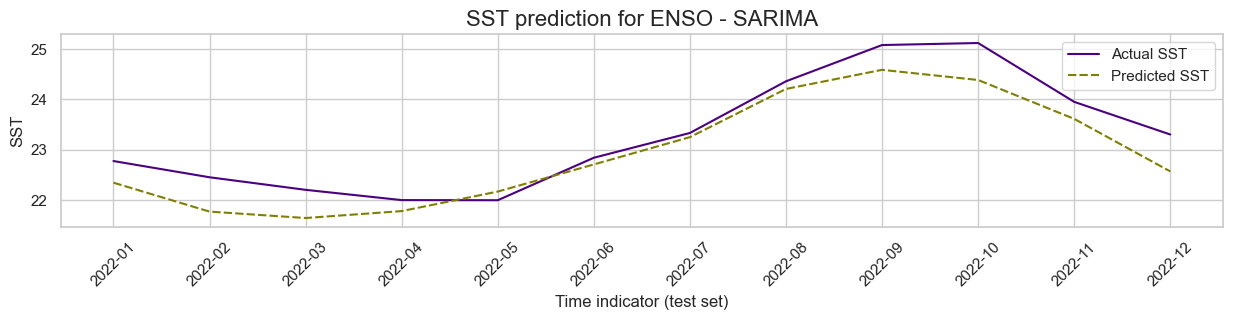

In [ ]:
SSTHelper.default_plot(y_atual_enso['sst'], y_predito_enso, 'ENSO - SARIMA', 'SARIMA')

### SARIMA: Usando a técnica walk-forward validation (somente para o ENSO)

Será realizada uma [**walk-forward validation**](https://www.tutorialspoint.com/time_series/time_series_walk_forward_validation.htm) que é muito boa para usar em projetos próprios de forecasting de séries temporais.

Primeiro, o modelo é treinado com o dataset de treino. Então, é realizada a predição no próximo passo em que a predição é avaliada em contraste com o valor conhecido. O dataset de treino é expandido para incluir o novo valor conhecido e o processo é repetido. 

Na prática o modelo SARIMAX é re-treinado em cada iteração do loop assim que novos pontos do histórico ficam disponíveis.

Re-treinar o modelo a cada iteração torna a predição mais robusta, entretanto, aumenta o custo computacional de ter esses vários modelos.


##### Deslocando o conjunto de teste em HORIZONTE de meses à frente

Essa etapa é realizada para conseguirmos validar as previsões para os meses que não existem no conjunto de teste (ou seja, os meses que serão previstos pelo modelo)

In [ ]:
teste_shifted_enso = teste_enso.copy() # faz uma cópia do conjunto de teste pois será deslocada no horizonte

for t in range(1, HORIZONTE):
    teste_shifted_enso['sst+'+str(t)] = teste_shifted_enso['sst'].shift(-t, freq='MS')
    
teste_shifted_enso = teste_shifted_enso.dropna(how='any')

#teste_shifted_enso.tail(HORIZONTE)

#### Criando os conjuntos de treino de acordo com a janela de treinamento

In [ ]:
JANELA_TREINAMENTO = 96 # meses de janela de treino (8 anos) 

treino_ts_enso = treino_enso['sst'] #pegando somente a coluna com as temperaturas médias
teste_ts_enso = teste_shifted_enso

# criando um historico com apenas os valores da temperatura
historico_enso = [x for x in treino_ts_enso] # fazendo split dos valores sst para o conjunto de treino
historico_enso = historico_enso[(-JANELA_TREINAMENTO):] # do final do conjunto de treino até o tamanho da janela (fim -> até(96))

#print(treino_enso['sst'])
#print("histórico:", historico_enso[:10])
print("Conjunto de treino para a JANELA DE TREINAMENTO de: ", JANELA_TREINAMENTO, "meses")
treino_ts_enso.tail(JANELA_TREINAMENTO)

Conjunto de treino para a JANELA DE TREINAMENTO de:  96 meses


time
2014-01-01    22.424427
2014-02-01    22.256029
2014-03-01    22.622278
2014-04-01    22.568365
2014-05-01    22.488226
                ...    
2021-08-01    24.145559
2021-09-01    24.596079
2021-10-01    24.381094
2021-11-01    23.861654
2021-12-01    23.306463
Name: sst, Length: 96, dtype: float32

In [ ]:
print("Conjunto de teste deslocado no HORIZONTE para os 12 meses:")
teste_ts_enso.tail(HORIZONTE)

Conjunto de teste deslocado no HORIZONTE para os 12 meses:


,sst,sst+1,sst+2,sst+3,sst+4,sst+5,sst+6,sst+7,sst+8,sst+9,sst+10,sst+11
time,,,,,,,,,,,,
2022-01-01,22.776232,22.454197,22.204994,22.001392,21.998831,22.841663,23.332996,24.358280,25.077301,25.117611,23.949959,23.302540
2022-02-01,22.454197,22.204994,22.001392,21.998831,22.841663,23.332996,24.358280,25.077301,25.117611,23.949959,23.302540,22.738529
2022-03-01,22.204994,22.001392,21.998831,22.841663,23.332996,24.358280,25.077301,25.117611,23.949959,23.302540,22.738529,21.955500
2022-04-01,22.001392,21.998831,22.841663,23.332996,24.358280,25.077301,25.117611,23.949959,23.302540,22.738529,21.955500,21.979300
2022-05-01,21.998831,22.841663,23.332996,24.358280,25.077301,25.117611,23.949959,23.302540,22.738529,21.955500,21.979300,21.770193
2022-06-01,22.841663,23.332996,24.358280,25.077301,25.117611,23.949959,23.302540,22.738529,21.955500,21.979300,21.770193,22.074417
2022-07-01,23.332996,24.358280,25.077301,25.117611,23.949959,23.302540,22.738529,21.955500,21.979300,21.770193,22.074417,22.585289
2022-08-01,24.358280,25.077301,25.117611,23.949959,23.302540,22.738529,21.955500,21.979300,21.770193,22.074417,22.585289,22.950830
2022-09-01,25.077301,25.117611,23.949959,23.302540,22.738529,21.955500,21.979300,21.770193,22.074417,22.585289,22.950830,24.066349


### Treino dos modelos para as janelas de treinamento com os parâmetros otimizados

In [ ]:
%%time
predicoes_enso = list()
for t in range(teste_ts_enso.shape[0]):
    # treinando o modelo SARIMA para o historico definido
    model_enso = SARIMAX(endog=historico_enso, order=order_enso, seasonal_order=sazonal_order_enso) #https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
    model_fit_enso = model_enso.fit()
    
    # realiza o forecast no HORIZONTE definido
    y_predito_enso = model_fit_enso.forecast(steps = HORIZONTE)
    
    # arredondando e adicionado à lista predições
    y_predito_enso = np.round(y_predito_enso, decimals = 1)
    predicoes_enso.append(y_predito_enso)
    
    # criando uma lista com os valores atuais
    y_atual_enso = list(teste_ts_enso.iloc[t]) # localiza o array do valor atual no índice t
    y_atual_enso = np.round(y_atual_enso, decimals = 1)
    
    # move the training window
    historico_enso.append(y_atual_enso[0])
    historico_enso.pop(0)
    
    print(t+1, '. Predicting time step: ', teste_ts_enso.index[t])
    print(t+1, ': predicted =', y_predito_enso)
    print(t+1, ': expected  =', y_atual_enso)
    print('----------')

1 . Predicting time step:  2022-01-01 00:00:00
1 : predicted = [22.6 22.  21.9 21.9 22.3 22.8 23.4 24.4 24.7 24.5 23.7 22.7]
1 : expected  = [22.8 22.5 22.2 22.  22.  22.8 23.3 24.4 25.1 25.1 23.9 23.3]
----------
2 . Predicting time step:  2022-02-01 00:00:00
2 : predicted = [22.3 22.1 22.2 22.5 23.  23.5 24.6 24.9 24.7 23.9 22.8 22.2]
2 : expected  = [22.5 22.2 22.  22.  22.8 23.3 24.4 25.1 25.1 23.9 23.3 22.7]
----------
3 . Predicting time step:  2022-03-01 00:00:00
3 : predicted = [22.4 22.4 22.6 23.1 23.6 24.7 25.1 24.8 24.  23.  22.3 22.2]
3 : expected  = [22.2 22.  22.  22.8 23.3 24.4 25.1 25.1 23.9 23.3 22.7 22. ]
----------
4 . Predicting time step:  2022-04-01 00:00:00
4 : predicted = [22.1 22.4 22.9 23.5 24.6 24.9 24.7 23.9 22.8 22.2 22.1 22.1]
4 : expected  = [22.  22.  22.8 23.3 24.4 25.1 25.1 23.9 23.3 22.7 22.  22. ]
----------
5 . Predicting time step:  2022-05-01 00:00:00
5 : predicted = [22.2 22.8 23.4 24.5 24.9 24.6 23.7 22.7 22.1 22.1 22.1 22.1]
5 : expected  = [22

#### Re-indexando as colunas para plotar o gráfico ao longo do tempo

In [ ]:
eval_df = pd.DataFrame(predicoes_enso, columns=['sst+'+str(t) for t in range(1, HORIZONTE+1)])
eval_df['timestamp'] = teste_enso.index[0:len(teste_enso.index)-HORIZONTE+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction_enso', var_name='h')
eval_df['atual'] = np.array(np.transpose(teste_ts_enso)).ravel()
eval_df.head(1250)

,timestamp,h,prediction_enso,atual
0,2022-01-01,sst+1,22.6,22.776232
1,2022-02-01,sst+1,22.3,22.454197
2,2022-03-01,sst+1,22.4,22.204994
3,2022-04-01,sst+1,22.1,22.001392
4,2022-05-01,sst+1,22.2,21.998831
...,...,...,...,...
127,2022-07-01,sst+12,23.0,22.585289
128,2022-08-01,sst+12,23.2,22.950830
129,2022-09-01,sst+12,24.2,24.066349
130,2022-10-01,sst+12,24.9,24.897844


#### Computando o MAPE: Mean Absolute Percentage Error sobre todas as predições e os valores atuais

O erro percentual absoluto médio ([MAPE](https://docs.oracle.com/cloud/help/pt_BR/pbcs_common/PFUSU/insights_metrics_MAPE.htm#PFUSU-GUID-C33B0F01-83E9-468B-B96C-413A12882334)) é uma medida de erro relativo que usa valores absolutos para impedir que os erros positivos e negativos cancelem uns aos outros e usa erros relativos para permitir que você compare a precisão da previsão entre métodos de série temporais.

$MAPE = \frac{1}{n} \sum_{t=1}^{n} |\frac{A_t - F_t}{A_t}|$ $->$ MAPE = Média de (abs((Atual - Forecast)/(Atual))

MAPE quanto menor o valor, melhor

In [ ]:
SSTHelper.mape(eval_df['atual'], eval_df['prediction_enso'])

0.0139372031187597

### Plotando as predições Versus valor atual para o horizonte de meses (t+1,...,t+12) - para o ENSO

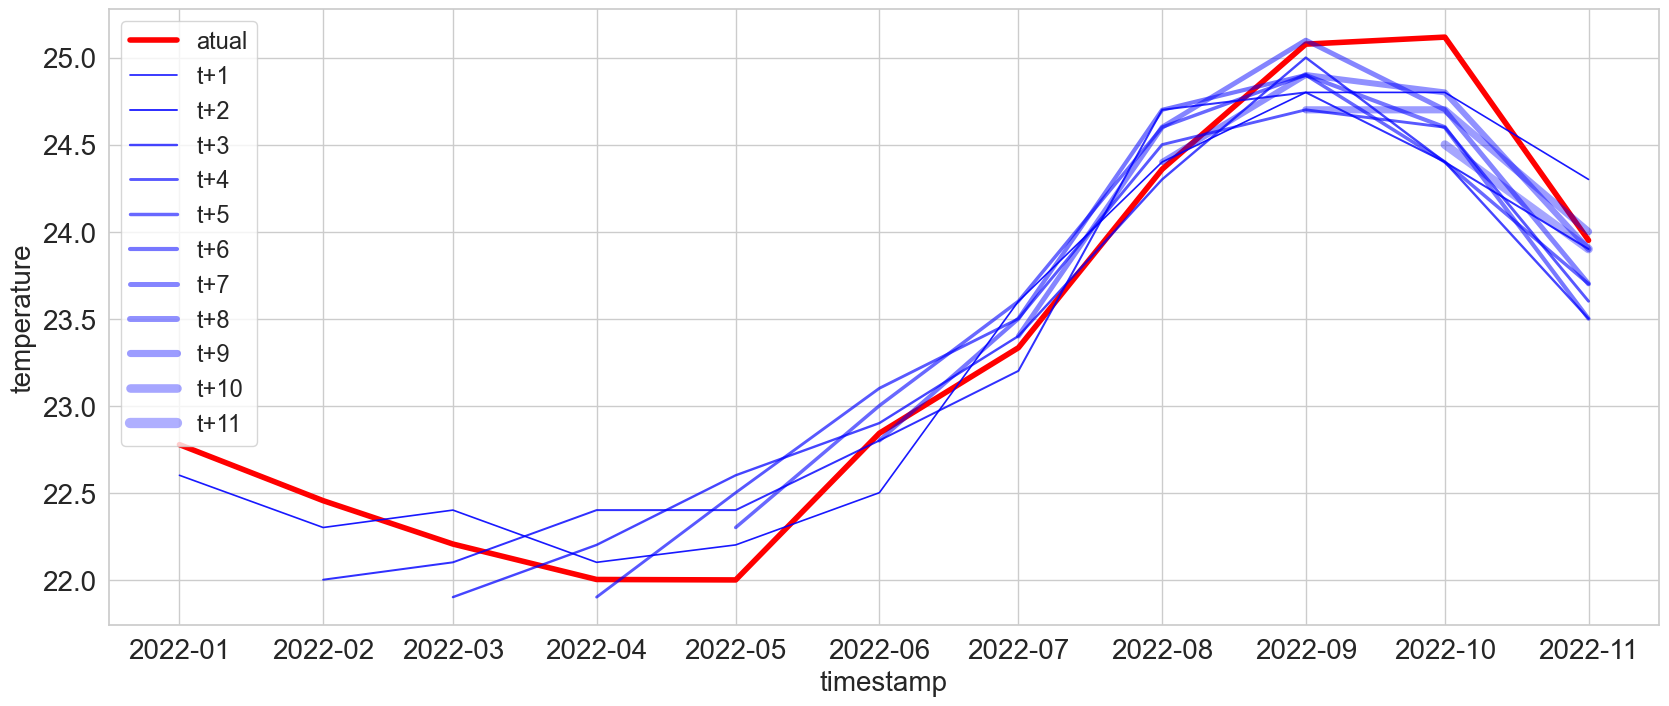

In [ ]:
## Plotting multi step forecast
plot_df = eval_df[(eval_df.h=='sst+1')][['timestamp', 'atual']]
for t in range(1, HORIZONTE):
    plot_df['t+'+str(t)] = eval_df[(eval_df.h=='sst+'+str(t))]['prediction_enso'].values

plot_df.head()
fig = plt.figure(figsize=(20, 8))
plt.plot(plot_df['timestamp'], plot_df['atual'], color='red', linewidth=4.0, label='atual')
plt.xticks(fontsize = 20)

for t in range(1, HORIZONTE):
    x = plot_df['timestamp'][(t-1):]
    y = plot_df['t+'+str(t)][0:len(x)]
    plt.plot(x, y, color='blue', linewidth=1*math.pow(1.2,t), alpha=math.pow(0.9,t), label='t+'+str(t))

plt.legend(fontsize = 17)
plt.yticks(fontsize = 20)
plt.xlabel('timestamp', fontsize=20)
plt.ylabel('temperature', fontsize=20)
plt.show()

### Algumas informações sobre o modelo treinado para SST

In [ ]:
print(model_fit_enso.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2757      0.139      1.989      0.047       0.004       0.547
ar.L2         -0.2107      0.190     -1.107      0.268      -0.584       0.162
ar.L3         -0.0382      0.172     -0.222      0.824      -0.376       0.299
ar.L4         -0.2664      0.112     -2.383      0.017      -0.486      -0.047
ar.L5         -0.0123      0.160     -0.077      0.939      -0.325       0.300
ar.S.L24      -0.8727      0.161     -5.436      0.000      -1.187      -0.558
ar.S.L48      -0.5091      0.128     -3.991      0.000      -0.759      -0.259
sigma2         0.0879      0.022      3.972      0.000       0.044       0.131


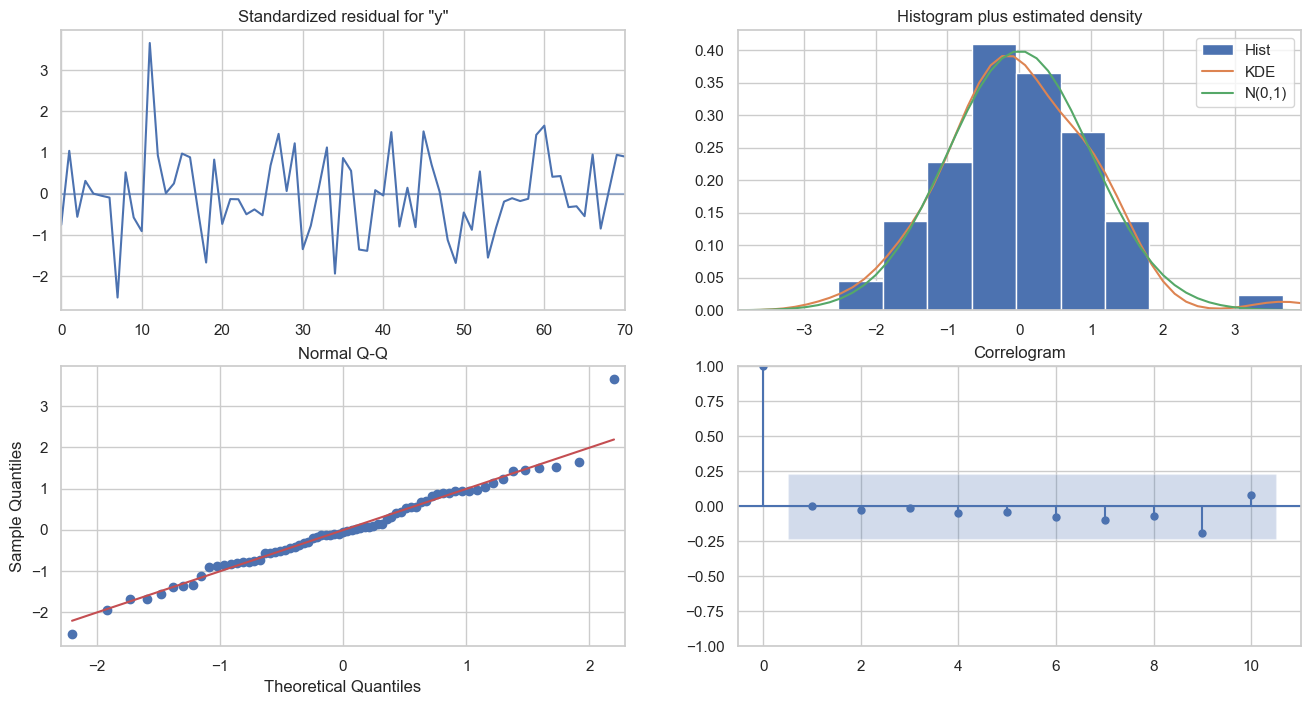

In [ ]:
model_fit_enso.plot_diagnostics(figsize=(16, 8))
plt.show()

## Anexo:

Realizando a previsão com o SARIMA para outros pontos do globo

In [ ]:
%load_ext autoreload
%autoreload 2
from netuno import SSTHelper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Dividindo em treino e teste para os outros pontos definidos (chile, mediterrâneo, atlântico, índico)

In [ ]:
# chile
treino_chile, teste_chile = SSTHelper.split_train_test(p2_chile, DATE_TO_SPLIT)
treino_chile.drop(['lat', 'lon'], axis=1, inplace=True)
teste_chile.drop(['lat', 'lon'], axis=1, inplace=True)

# mediterrâneo
treino_medit, teste_medit = SSTHelper.split_train_test(p3_medit, DATE_TO_SPLIT)
treino_medit.drop(['lat', 'lon'], axis=1, inplace=True)
teste_medit.drop(['lat', 'lon'], axis=1, inplace=True)

# atlântico
treino_atlan, teste_atlan = SSTHelper.split_train_test(p4_atlan, DATE_TO_SPLIT)
treino_atlan.drop(['lat', 'lon'], axis=1, inplace=True)
teste_atlan.drop(['lat', 'lon'], axis=1, inplace=True)

# ìndico
treino_indic, teste_indic = SSTHelper.split_train_test(p5_indic, DATE_TO_SPLIT)
treino_indic.drop(['lat', 'lon'], axis=1, inplace=True)
teste_indic.drop(['lat', 'lon'], axis=1, inplace=True)

#### Treinando os modelos para todos os pontos restantes

In [ ]:
# parâmetro obtidos do otimizador auto_arima
order_geral         = (5, 1, 0) #(p, q, d)
sazonal_order_geral = (2, 1, 0, 24) #(P, Q, D, m)

model_chile = SARIMAX(endog=treino_chile, order=order_geral, seasonal_order=sazonal_order_geral)
model_fit_chile = model_chile.fit()
y_predito_chile = model_fit_chile.forecast(steps = HORIZONTE)

model_medit = SARIMAX(endog=treino_medit, order=order_geral, seasonal_order=sazonal_order_geral)
model_fit_medit = model_medit.fit()
y_predito_medit = model_fit_medit.forecast(steps = HORIZONTE)

model_atlan = SARIMAX(endog=treino_atlan, order=order_geral, seasonal_order=sazonal_order_geral)
model_fit_atlan = model_atlan.fit()
y_predito_atlan = model_fit_atlan.forecast(steps = HORIZONTE)

model_indic = SARIMAX(endog=treino_indic, order=order_geral, seasonal_order=sazonal_order_geral)
model_fit_indic = model_indic.fit()
y_predito_indic = model_fit_indic.forecast(steps = HORIZONTE)

#### Pegando as subseries para os pontos

In [ ]:
y_atual_chile = SSTHelper.get_subseries_by_date(teste_chile, DATE_TO_SPLIT, END_WINDOW)
y_atual_medit = SSTHelper.get_subseries_by_date(teste_medit, DATE_TO_SPLIT, END_WINDOW)
y_atual_atlan = SSTHelper.get_subseries_by_date(teste_atlan, DATE_TO_SPLIT, END_WINDOW)
y_atual_indic = SSTHelper.get_subseries_by_date(teste_indic, DATE_TO_SPLIT, END_WINDOW)

#### Calculando os erros RMSE e MAPE:

In [ ]:
rmse_chile = SSTHelper.rmse(y_atual_chile, y_predito_chile)
mape_chile = SSTHelper.mape(y_atual_chile, y_predito_chile)

rmse_medit = SSTHelper.rmse(y_atual_medit , y_predito_medit)
mape_medit = SSTHelper.mape(y_atual_medit , y_predito_medit)

rmse_atlan = SSTHelper.rmse(y_atual_atlan, y_predito_atlan)
mape_atlan = SSTHelper.mape(y_atual_atlan, y_predito_atlan)

rmse_indic = SSTHelper.rmse(y_atual_indic, y_predito_indic)
mape_indic = SSTHelper.mape(y_atual_indic, y_predito_indic)

print("RMSE (Chile)", rmse_chile)
print("MAPE (Chile)", mape_chile)
print("----------------------\n")
print("RMSE (Mediterrâneo)", rmse_medit)
print("MAPE (Mediterrâneo)", mape_medit)
print("----------------------\n")
print("RMSE (Atlântico)", rmse_atlan)
print("MAPE (Atlântico)", mape_atlan)
print("----------------------\n")
print("RMSE (Índico)", rmse_indic)
print("MAPE (Índico)", mape_indic)
print("----------------------\n")

RMSE (Chile) 0.31612995922181814
MAPE (Chile) 0.013907741795411266
----------------------

RMSE (Mediterrâneo) 0.7618892609116027
MAPE (Mediterrâneo) 0.03000699753349101
----------------------

RMSE (Atlântico) 0.5083014279162089
MAPE (Atlântico) 0.017577316283200906
----------------------

RMSE (Índico) 0.20295235199686473
MAPE (Índico) 0.34931100095740125
----------------------



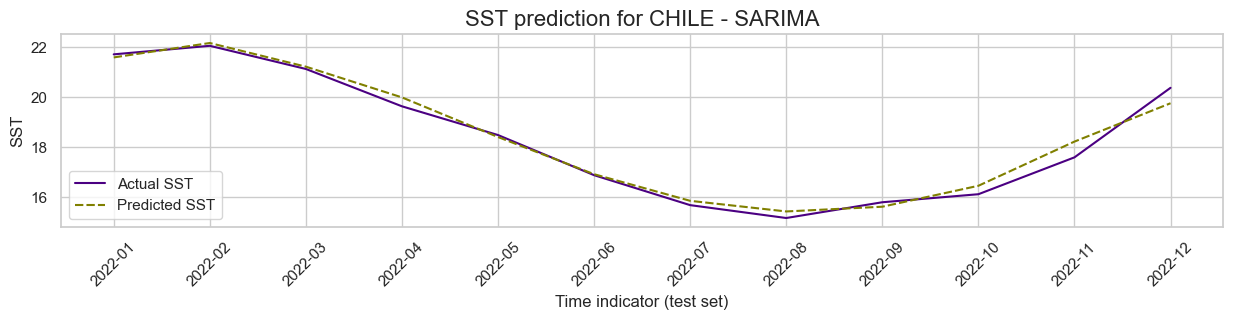

In [ ]:
SSTHelper.default_plot(y_atual_chile['sst'], y_predito_chile, 'CHILE - SARIMA', 'SARIMA')

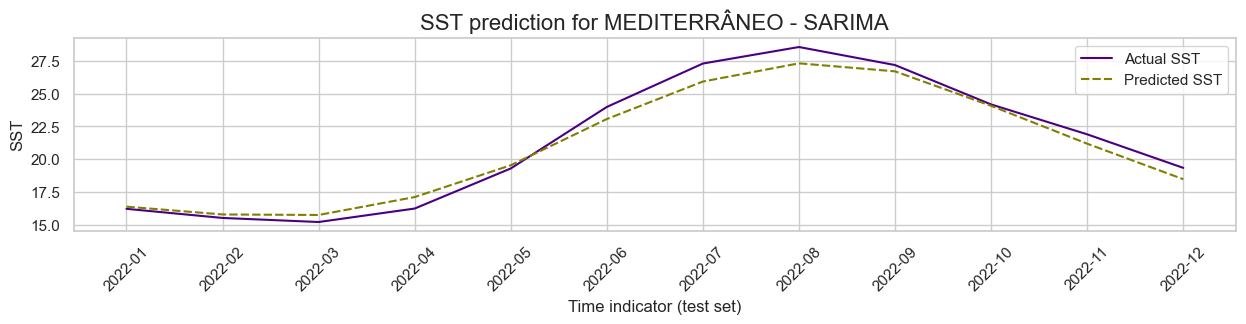

In [ ]:
SSTHelper.default_plot(y_atual_medit['sst'], y_predito_medit, 'MEDITERRÂNEO - SARIMA', 'SARIMA')

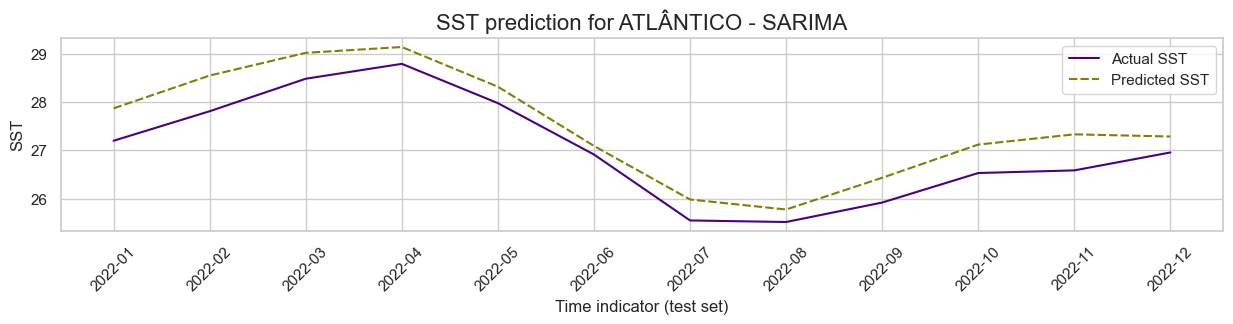

In [ ]:
SSTHelper.default_plot(y_atual_atlan['sst'], y_predito_atlan, 'ATLÂNTICO - SARIMA', 'SARIMA')

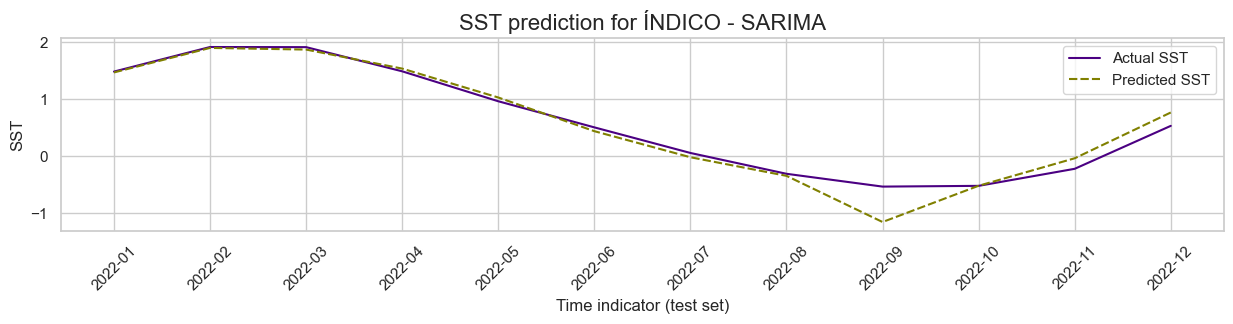

In [ ]:
SSTHelper.default_plot(y_atual_indic['sst'], y_predito_indic, 'ÍNDICO - SARIMA', 'SARIMA')

## Teste Expandido
Nessa seçao iremos expandir a quantidade de testes, executando o SARIMA para cerca de 100 séries temporais

#### Lendo os pontos pré-definidos

In [2]:
from tqdm import tqdm

def read_list_points(filename):
    list_points = []
    with open(filename, 'r') as file:
        for line in file:
            line_split = line.split(',')
            try:
                list_points.append((int(line_split[1]), int(line_split[2])))
            except ValueError:
                pass
    return list_points

In [3]:
list_points = read_list_points('../dados/pontos.csv')

In [4]:
order_geral         = (5, 1, 0) #(p, q, d)
sazonal_order_geral = (2, 1, 0, 24) #(P, Q, D, m)
HORIZONTE = END_WINDOW = 12 # número de previsões a serem feitas (à frente da data)
AUTO_TUNE = True # se False, não faz a otimização de hiperparâmetros com o auto_arima (demorado)
DATE_TO_SPLIT = '2021-12-01' #data limite para dividir em treino[:DATA_LIMITE] e teste[DATA_LIMITE:]

#### Rodando o SARIMA e calculando o erro

In [14]:
error_list = []

for point_coordinates in tqdm(list_points):
    
    point_series = SSTHelper.get_sst_series_default(df,point_coordinates[0], point_coordinates[1])
    treino_point, teste_point = SSTHelper.split_train_test(point_series, DATE_TO_SPLIT)
    treino_point.drop(['lat', 'lon'], axis=1, inplace=True)
    teste_point.drop(['lat', 'lon'], axis=1, inplace=True)

    model = SARIMAX(endog=treino_point, order=order_geral, seasonal_order=sazonal_order_geral)
    model_fit = model.fit()
    y_predito = model_fit.forecast(steps = HORIZONTE)

    y_atual = SSTHelper.get_subseries_by_date(teste_point, DATE_TO_SPLIT, END_WINDOW)

    rmse = SSTHelper.rmse(y_atual, y_predito)
    mape = SSTHelper.mape(y_atual, y_predito)

    error_list.append((rmse, mape))
    
    print(f'lat: {point_coordinates[0]}; lon:{point_coordinates[1]}')
    print("RMSE:", rmse, "\nMAPE:", mape)

  1%|          | 1/100 [00:08<13:31,  8.20s/it]

lat: -50; lon:84
RMSE: 0.13071301069752753 
MAPE: 0.0239406754503113


  2%|▏         | 2/100 [00:15<12:07,  7.42s/it]

lat: 30; lon:174
RMSE: 0.8782894849997522 
MAPE: 0.0371526905578389


  3%|▎         | 3/100 [00:48<31:08, 19.27s/it]

lat: 88; lon:8
RMSE: 0.0810734420461785 
MAPE: 0.013015003581084242


  4%|▍         | 4/100 [00:56<23:27, 14.66s/it]

lat: -66; lon:32
RMSE: 0.04361068863751367 
MAPE: 0.055479951152595706


  5%|▌         | 5/100 [01:07<21:20, 13.48s/it]

lat: -68; lon:-20
RMSE: 0.08330137092239873 
MAPE: 0.05597162008399257


  6%|▌         | 6/100 [01:13<17:17, 11.03s/it]

lat: 24; lon:-120
RMSE: 0.45934442048711804 
MAPE: 0.01632915816328327


  7%|▋         | 7/100 [01:19<14:12,  9.17s/it]

lat: 44; lon:38
RMSE: 0.7858556557399128 
MAPE: 0.03615112856523734


  8%|▊         | 8/100 [01:27<13:42,  8.94s/it]

lat: -46; lon:-136
RMSE: 0.2388279660508836 
MAPE: 0.021691845909793422


  9%|▉         | 9/100 [01:34<12:45,  8.41s/it]

lat: -60; lon:-108
RMSE: 0.22981051437699979 
MAPE: 0.07185828095744322


 10%|█         | 10/100 [01:42<12:31,  8.35s/it]

lat: -42; lon:-72
RMSE: 0.46277612357897485 
MAPE: 0.03411437454254521


 11%|█         | 11/100 [01:48<11:18,  7.62s/it]

lat: 54; lon:-22
RMSE: 0.5010169838948753 
MAPE: 0.03043689093134003


 12%|█▏        | 12/100 [01:57<11:26,  7.80s/it]

lat: 20; lon:-24
RMSE: 0.3668811461220175 
MAPE: 0.014118645835862623


 13%|█▎        | 13/100 [02:05<11:28,  7.92s/it]

lat: -58; lon:-160
RMSE: 0.20490602128161622 
MAPE: 0.08868964167091137


 14%|█▍        | 14/100 [02:14<11:48,  8.24s/it]

lat: -66; lon:-12
RMSE: 0.06908653473048651 
MAPE: 0.05137526813797471


 15%|█▌        | 15/100 [02:25<12:57,  9.15s/it]

lat: -50; lon:134
RMSE: 0.29307386812877395 
MAPE: 0.03424308357862823


 16%|█▌        | 16/100 [02:35<13:08,  9.39s/it]

lat: 80; lon:-4
RMSE: 0.5973772700864358 
MAPE: 0.16131317854770852


 17%|█▋        | 17/100 [02:42<11:48,  8.53s/it]

lat: -16; lon:-36
RMSE: 0.4277818970801211 
MAPE: 0.01317550659848598


 18%|█▊        | 18/100 [02:49<11:05,  8.11s/it]

lat: -66; lon:-110
RMSE: 0.2845611638872162 
MAPE: 0.2581489991002701


 19%|█▉        | 19/100 [02:58<11:30,  8.53s/it]

lat: -8; lon:-22
RMSE: 0.24562952638288477 
MAPE: 0.008091502169163435


 20%|██        | 20/100 [03:06<11:08,  8.36s/it]

lat: 40; lon:-10
RMSE: 0.4759014709719862 
MAPE: 0.02313017798701732


 21%|██        | 21/100 [03:14<10:54,  8.28s/it]

lat: -50; lon:-120
RMSE: 0.4613734038685141 
MAPE: 0.055382123931847556


 22%|██▏       | 22/100 [03:28<12:50,  9.87s/it]

lat: -74; lon:-142
RMSE: 0.025574829265562034 
MAPE: 0.00412426313238565


 23%|██▎       | 23/100 [03:34<11:20,  8.84s/it]

lat: 72; lon:52
RMSE: 1.1750923848674584 
MAPE: 0.5833261117767579


 24%|██▍       | 24/100 [03:45<11:54,  9.41s/it]

lat: -56; lon:22
RMSE: 0.45235752252463024 
MAPE: 1.8796577301176176


 25%|██▌       | 25/100 [03:51<10:32,  8.44s/it]

lat: -36; lon:98
RMSE: 0.3417674792878509 
MAPE: 0.020206459435118587


 26%|██▌       | 26/100 [03:57<09:36,  7.79s/it]

lat: 48; lon:-40
RMSE: 0.9508121084896503 
MAPE: 0.055184666249655574


 27%|██▋       | 27/100 [04:03<08:48,  7.23s/it]

lat: 74; lon:-76
RMSE: 0.11626330301756671 
MAPE: 0.059223220835829836


 28%|██▊       | 28/100 [04:16<10:45,  8.96s/it]

lat: -72; lon:-142
RMSE: 0.0534459372658385 
MAPE: 0.015868028895543982


 29%|██▉       | 29/100 [04:24<10:08,  8.57s/it]

lat: 80; lon:74
RMSE: 0.7565588299953692 
MAPE: 0.6991066139736541


 30%|███       | 30/100 [04:34<10:27,  8.97s/it]

lat: 4; lon:-156
RMSE: 0.6201961072401546 
MAPE: 0.020402310556482686


 31%|███       | 31/100 [04:44<10:37,  9.24s/it]

lat: -54; lon:168
RMSE: 0.20404398799118267 
MAPE: 0.023033637855315207


 32%|███▏      | 32/100 [04:50<09:34,  8.44s/it]

lat: -44; lon:44
RMSE: 0.47531289181040887 
MAPE: 0.04346362276370408


 33%|███▎      | 33/100 [04:57<08:42,  7.80s/it]

lat: 34; lon:-174
RMSE: 0.8122898003597563 
MAPE: 0.03797638784610924


 34%|███▍      | 34/100 [05:07<09:15,  8.42s/it]

lat: -58; lon:164
RMSE: 0.21589874960002392 
MAPE: 0.03906803946090056


 35%|███▌      | 35/100 [05:16<09:35,  8.85s/it]

lat: -66; lon:4
RMSE: 0.034191277010264406 
MAPE: 0.24553257756765656


 36%|███▌      | 36/100 [05:23<08:35,  8.06s/it]

lat: 52; lon:-132
RMSE: 0.8490467637578619 
MAPE: 0.048169890360882865


 37%|███▋      | 37/100 [05:29<07:58,  7.60s/it]

lat: 52; lon:-4
RMSE: 0.611062151530116 
MAPE: 0.0404902604034144


 38%|███▊      | 38/100 [05:37<07:55,  7.66s/it]

lat: -50; lon:40
RMSE: 0.40514715155829145 
MAPE: 0.11169764597798061


 39%|███▉      | 39/100 [05:46<08:17,  8.15s/it]

lat: -42; lon:126
RMSE: 0.6160433914229599 
MAPE: 0.048501575930191054


 40%|████      | 40/100 [05:55<08:25,  8.42s/it]

lat: -52; lon:-86
RMSE: 0.18693620733416322 
MAPE: 0.022481229334311268


 41%|████      | 41/100 [06:03<08:09,  8.30s/it]

lat: -10; lon:-16
RMSE: 0.19330139163118348 
MAPE: 0.006635928449533024


 42%|████▏     | 42/100 [06:12<08:01,  8.30s/it]

lat: 28; lon:-142
RMSE: 0.8374656721871266 
MAPE: 0.03425438547441766


 43%|████▎     | 43/100 [06:21<08:10,  8.60s/it]

lat: -70; lon:-28
RMSE: 0.12257456451323989 
MAPE: 0.04729275262285945


 44%|████▍     | 44/100 [06:27<07:25,  7.95s/it]

lat: 36; lon:164
RMSE: 0.9135106341013065 
MAPE: 0.04559482635464423


 45%|████▌     | 45/100 [06:34<07:01,  7.66s/it]

lat: -12; lon:60
RMSE: 0.3167864752302223 
MAPE: 0.010271503599097022


 46%|████▌     | 46/100 [06:41<06:41,  7.44s/it]

lat: 30; lon:-26
RMSE: 0.5978625926683128 
MAPE: 0.02049202754332439


 47%|████▋     | 47/100 [07:21<15:04, 17.07s/it]

lat: 86; lon:-162
RMSE: 0.08771544292362174 
MAPE: 0.017831453837141655


 48%|████▊     | 48/100 [07:27<12:00, 13.85s/it]

lat: -46; lon:-64
RMSE: 0.9696448904142577 
MAPE: 0.0773582916253963


 49%|████▉     | 49/100 [07:34<09:55, 11.68s/it]

lat: -26; lon:88
RMSE: 0.4461978933008284 
MAPE: 0.017740385522056184


 50%|█████     | 50/100 [07:42<08:58, 10.77s/it]

lat: -60; lon:-54
RMSE: 0.23638350438420563 
MAPE: 0.35355122739311234


 51%|█████     | 51/100 [07:50<08:08,  9.96s/it]

lat: -42; lon:174
RMSE: 0.24425833149489537 
MAPE: 0.014534632775338431


 52%|█████▏    | 52/100 [07:57<07:08,  8.93s/it]

lat: 52; lon:144
RMSE: 1.9256044742006226 
MAPE: 0.5807598626061546


 53%|█████▎    | 53/100 [08:15<09:04, 11.60s/it]

lat: 84; lon:-148
RMSE: 0.0 
MAPE: 0.0


 54%|█████▍    | 54/100 [08:21<07:43, 10.07s/it]

lat: -26; lon:154
RMSE: 0.603657940352548 
MAPE: 0.02194551441166892


 55%|█████▌    | 55/100 [08:31<07:32, 10.05s/it]

lat: -56; lon:122
RMSE: 0.16073744068989282 
MAPE: 0.051660672063426005


 56%|█████▌    | 56/100 [08:39<06:46,  9.24s/it]

lat: 6; lon:170
RMSE: 0.3699916524078381 
MAPE: 0.011318031627132784


 57%|█████▋    | 57/100 [08:45<06:01,  8.40s/it]

lat: 28; lon:-156
RMSE: 0.8473768833292481 
MAPE: 0.029288742583845437


 58%|█████▊    | 58/100 [08:51<05:26,  7.77s/it]

lat: -46; lon:-160
RMSE: 0.317110941421644 
MAPE: 0.023265849196487595


 59%|█████▉    | 59/100 [08:57<04:56,  7.23s/it]

lat: 42; lon:-38
RMSE: 0.9987584155091557 
MAPE: 0.0511447150103298


 60%|██████    | 60/100 [09:05<04:55,  7.40s/it]

lat: -12; lon:46
RMSE: 0.18727483933190703 
MAPE: 0.005940936663769182


 61%|██████    | 61/100 [09:12<04:40,  7.19s/it]

lat: 34; lon:-76
RMSE: 0.45511888584644633 
MAPE: 0.013823273218315127


 62%|██████▏   | 62/100 [09:20<04:40,  7.39s/it]

lat: -52; lon:-82
RMSE: 0.19242441886113035 
MAPE: 0.023336587207517506


 63%|██████▎   | 63/100 [09:31<05:16,  8.56s/it]

lat: -12; lon:110
RMSE: 0.36623471184896345 
MAPE: 0.011659887293546577


 64%|██████▍   | 64/100 [09:38<04:48,  8.01s/it]

lat: -42; lon:-32
RMSE: 0.43533034316854863 
MAPE: 0.024172358907625924


 65%|██████▌   | 65/100 [09:44<04:23,  7.52s/it]

lat: 50; lon:-4
RMSE: 0.6302372487045882 
MAPE: 0.03849615668360357


 66%|██████▌   | 66/100 [09:56<04:58,  8.77s/it]

lat: 84; lon:92
RMSE: 0.11878177889985941 
MAPE: 0.030910464436392133


 67%|██████▋   | 67/100 [10:02<04:27,  8.11s/it]

lat: 62; lon:-30
RMSE: 0.5003436696571059 
MAPE: 0.04401577354281766


 68%|██████▊   | 68/100 [10:10<04:15,  7.98s/it]

lat: -64; lon:-8
RMSE: 0.14432885879317991 
MAPE: 0.1039271723799941


 69%|██████▉   | 69/100 [10:16<03:53,  7.52s/it]

lat: 24; lon:68
RMSE: 0.48478789003887746 
MAPE: 0.01532519746548172


 70%|███████   | 70/100 [10:22<03:24,  6.83s/it]

lat: 66; lon:22
RMSE: 1.2736255897410742 
MAPE: 1.2830299497728237


 71%|███████   | 71/100 [10:30<03:27,  7.15s/it]

lat: -14; lon:96
RMSE: 0.33872063701049687 
MAPE: 0.010529734725807365


 72%|███████▏  | 72/100 [10:40<03:49,  8.18s/it]

lat: -64; lon:156
RMSE: 0.1870557162347389 
MAPE: 0.2025007011797302


 73%|███████▎  | 73/100 [10:47<03:28,  7.72s/it]

lat: 58; lon:176
RMSE: 0.5989891300112548 
MAPE: 0.0891581728967329


 74%|███████▍  | 74/100 [10:52<02:59,  6.90s/it]

lat: 60; lon:-56
RMSE: 0.6954881828405179 
MAPE: 0.27629820833611496


 75%|███████▌  | 75/100 [11:00<02:58,  7.13s/it]

lat: 10; lon:-130
RMSE: 0.1252449534566192 
MAPE: 0.003302124267532696


 76%|███████▌  | 76/100 [11:06<02:44,  6.86s/it]

lat: 16; lon:-16
RMSE: 1.1917706775953933 
MAPE: 0.04468312101733205


 77%|███████▋  | 77/100 [11:12<02:34,  6.70s/it]

lat: 62; lon:-10
RMSE: 0.36941216936046395 
MAPE: 0.03411414774346961


 78%|███████▊  | 78/100 [11:17<02:18,  6.30s/it]

lat: 74; lon:74
RMSE: 0.5911884895921091 
MAPE: 0.21156545030925858


 79%|███████▉  | 79/100 [11:24<02:13,  6.38s/it]

lat: 24; lon:134
RMSE: 0.6770775536692805 
MAPE: 0.019606372828964415


 80%|████████  | 80/100 [11:30<02:06,  6.33s/it]

lat: 28; lon:-24
RMSE: 0.5951478314677243 
MAPE: 0.02104450238990238


 81%|████████  | 81/100 [11:36<02:00,  6.32s/it]

lat: 50; lon:-146
RMSE: 1.4814913719216336 
MAPE: 0.16198084933453852


 82%|████████▏ | 82/100 [11:43<01:56,  6.47s/it]

lat: -42; lon:-92
RMSE: 0.49018744770283135 
MAPE: 0.033984831177178876


 83%|████████▎ | 83/100 [11:51<01:54,  6.71s/it]

lat: 12; lon:-112
RMSE: 0.12093706044915824 
MAPE: 0.0033701871523897334


 84%|████████▍ | 84/100 [11:58<01:51,  6.98s/it]

lat: -34; lon:-152
RMSE: 0.4866182478545051 
MAPE: 0.025228622709169018


 85%|████████▌ | 85/100 [12:04<01:40,  6.70s/it]

lat: 22; lon:-154
RMSE: 0.9733410153108979 
MAPE: 0.03637580244098775


 86%|████████▌ | 86/100 [12:13<01:41,  7.23s/it]

lat: -62; lon:-150
RMSE: 0.24694391933053475 
MAPE: 0.2566141325922215


 87%|████████▋ | 87/100 [12:19<01:28,  6.84s/it]

lat: 28; lon:152
RMSE: 0.8357808874916546 
MAPE: 0.03164265669299636


 88%|████████▊ | 88/100 [12:26<01:22,  6.85s/it]

lat: -24; lon:4
RMSE: 0.6275110245315043 
MAPE: 0.025611074110510987


 89%|████████▉ | 89/100 [12:34<01:20,  7.29s/it]

lat: -50; lon:-158
RMSE: 0.21078459901681992 
MAPE: 0.018957862521096887


 90%|█████████ | 90/100 [12:40<01:10,  7.02s/it]

lat: 40; lon:-146
RMSE: 0.6634755455749496 
MAPE: 0.03794679604990026


 91%|█████████ | 91/100 [12:48<01:05,  7.24s/it]

lat: 78; lon:146
RMSE: 0.39005381415398865 
MAPE: 0.23665286615612824


 92%|█████████▏| 92/100 [13:06<01:23, 10.44s/it]

lat: 86; lon:-12
RMSE: 0.0 
MAPE: 0.0


 93%|█████████▎| 93/100 [13:13<01:05,  9.31s/it]

lat: -34; lon:-50
RMSE: 0.6942192719678298 
MAPE: 0.030739370053598617


 94%|█████████▍| 94/100 [13:37<01:23, 13.93s/it]

lat: 84; lon:18
RMSE: 0.16293393607138132 
MAPE: 0.03311501541563569


 95%|█████████▌| 95/100 [13:43<00:57, 11.56s/it]

lat: -28; lon:2
RMSE: 0.6462660846107543 
MAPE: 0.02544881373274442


 96%|█████████▌| 96/100 [13:53<00:44, 11.10s/it]

lat: -64; lon:46
RMSE: 0.0826202478186193 
MAPE: 0.08708005987647016


 97%|█████████▋| 97/100 [13:59<00:28,  9.45s/it]

lat: -12; lon:-90
RMSE: 0.33864569156444785 
MAPE: 0.011532845942830662


 98%|█████████▊| 98/100 [14:06<00:17,  8.83s/it]

lat: -2; lon:158
RMSE: 0.3485383697031938 
MAPE: 0.01039175594818142


 99%|█████████▉| 99/100 [14:13<00:08,  8.20s/it]

lat: 34; lon:172
RMSE: 1.0222295456283064 
MAPE: 0.045906300965395073


100%|██████████| 100/100 [14:22<00:00,  8.62s/it]

lat: 12; lon:50
RMSE: 0.21563372088258417 
MAPE: 0.005977273340356116


#### Salvando os resultados

In [15]:
results_df = pd.DataFrame(error_list)
results_df.rename({0: 'rmse', 1: 'mape'}, axis=1).to_csv('../dados/sarima_results.csv')    

#### Referências

Este projeto é uma adaptação das seguintes referências:

https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/2-ARIMA/README.md

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/

https://www.kaggle.com/code/ishanharshvardhan/time-series-analysis-and-forecasting-using-arima

